In [1]:
import numpy as np
from scipy.linalg import eig, eig_banded, eigh
from scipy.sparse.linalg import eigs, eigsh
from scipy.sparse import eye, diags
import kwant
from math import floor
from scipy.integrate import quad
import matplotlib.pyplot as plt

In [2]:
%%time
N = 200
eps = 0.1
a = 0.1
b = np.linspace(-1, 1, N)
H = diags(b, offsets=0)

Emin = eigsh(H, k=1, which='SA', return_eigenvectors=False)[0]
Emax = eigsh(H, k=1, which='LA', return_eigenvectors=False)[0]
E_max_abs = np.max(np.abs([Emax, Emin]))


def G_operator(ham, Emax, Emin):
    Emax=Emax*(1 + eps)
    Emin=Emin*(1 + eps)
    E0 = (Emax - Emin)/2
    Ec = (Emax + Emin)/2
    return (ham - eye(ham.shape[0]) * Ec)/E0


def F_operator(ham, Emax, a):
    Emax=Emax*(1 + eps)
    E0 = (Emax**2 - a**2)/2
    Ec = (Emax**2 + a**2)/2
    return (ham @ ham - eye(ham.shape[0])*Ec)/E0

G = G_operator(H, Emax, Emin)
F = F_operator(H, E_max_abs, a)
a_r = a/E_max_abs


dos_estimate = kwant.kpm.SpectralDensity(
    H,
    energy_resolution=2*a,
    mean=True,
    bounds=(Emin, Emax)
)

d=int(np.abs(dos_estimate(0)*2*a))
d

CPU times: user 29.2 ms, sys: 6.24 ms, total: 35.5 ms
Wall time: 31.7 ms


18

In [3]:
def low_E_filter(v_rand, matrix, k):
    for i in range(k+1):
        if i == 0:
            v_n = v_rand
            continue

        elif i == 1:
            v_nm1 = v_n
            v_n = matrix @ v_nm1
            continue
        else:
            v_np1 = 2*matrix @ v_n - v_nm1
            v_nm1 = v_n
            v_n = v_np1
    return v_n/np.linalg.norm(v_n)


def basis(v_proj, matrix, indices):
    v_basis = []
    # TODO: If k is too large, the norms of the vectors are from some large order.
    k = indices[-1]
    for i in range(k+1):
        if i == 0:
            v_n = v_proj
            continue
        elif i == 1:
            v_nm1 = v_n
            v_n = matrix @ v_nm1
            continue
        else:
            v_np1 = 2 * matrix @ v_n - v_nm1
            v_nm1 = v_n
            v_n = v_np1
        if i in indices:
            v_basis.append(v_n / np.linalg.norm(v_n))
    return np.asarray(v_basis)



def basis_no_store(v_proj, matrix, H, indices_to_store):
    S_xy = []
    H_xy = []
    # TODO: If k is too large, the norms of the vectors are from some large order.
    k = indices_to_store[-1]
    for i in range(k+1):
        if i == 0:
            v_n = v_proj
            continue
        elif i == 1:
            v_nm1 = v_n
            v_n = matrix @ v_nm1
            continue
        else:
            v_np1 = 2 * matrix @ v_n - v_nm1
            v_nm1 = v_n
            v_n = v_np1
        if i in indices_to_store:
            v_store = v_n / np.linalg.norm(v_n)
            S_xy.append(v_proj.conj() @ v_store.T)
            H_xy.append(v_proj.conj() @ matrix @ v_store)
    return np.asarray(S_xy), np.asarray(H_xy)


CPU times: user 60.4 ms, sys: 13.1 ms, total: 73.5 ms
Wall time: 72.9 ms


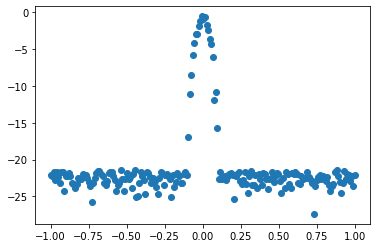

In [4]:
%%time
true_eigvals, true_eigvecs = eigh(H.todense())


ψ_rand = 2 * (np.random.rand(N) + np.random.rand(N)*1j - 0.5 * (1 + 1j))
ψ_rand = ψ_rand/np.linalg.norm(ψ_rand)
ψ_proj = low_E_filter(ψ_rand, F, int(12*E_max_abs/a))

plt.scatter(np.real(true_eigvals), np.log(np.abs(true_eigvecs.T.conj()@ψ_proj)))

In [5]:
# Needed factor of 2 here
n = int(np.abs((d*2 - 1)/2))
a_r = a / np.max(np.abs([Emin, Emax]))
dk = np.pi / a_r
n_array = np.arange(1, 2*n+1, 1)
indices = np.floor(n_array * dk)
indices_to_store = np.unique(
    np.array([0, 1, *indices-2, *indices-1, *indices, *indices+1])
).astype(int)
n_array_basis = np.arange(1, n+1, 1)
indices_half = np.floor(n_array_basis * dk)
indices_basis = np.unique(np.array([0, *indices_half-1, *indices_half])).astype(int)

S_xy, H_xy = basis_no_store(
    v_proj=ψ_proj,
    matrix=G,
    H=H,
    indices_to_store=indices_to_store
)

S = np.zeros((n, n), dtype=np.complex128)
H = np.zeros((n, n), dtype=np.complex128)
lole = []
for count_i, i in enumerate(indices_basis):
    for count_j, j in enumerate(indices_basis):
        kp = i+j
        km = abs(i-j)
        ind_p = np.where(indices_to_store == kp)[0][0]
        ind_m = np.where(indices_to_store == km)[0][0]
        S[count_i, count_j] = 0.5 * (S_xy[ind_p] + S_xy[ind_m])
        H[count_i, count_j] = 0.5 * (H_xy[ind_p] + H_xy[ind_m])
lole = np.array(lole)

n = int((d*2 - 1)/2)
n_array = np.arange(1, n+1, 1)
indicesp1 = (n_array*np.pi/a_r).astype(int)
indices = np.sort(np.array([*indicesp1, *indicesp1-1]))

ψ_basis = basis(ψ_proj, G, indices)
S_true = ψ_basis.conj()@ψ_basis.T

IndexError: index 17 is out of bounds for axis 1 with size 17

In [15]:
ind_m

35

In [10]:
dk

31.415926535897913

In [11]:
km

281

In [12]:
kp

281

In [17]:
indices_to_store

array([   0,    1,   29,   30,   31,   32,   60,   61,   62,   63,   92,
         93,   94,   95,  123,  124,  125,  126,  155,  156,  157,  158,
        186,  187,  188,  189,  217,  218,  219,  220,  249,  250,  251,
        252,  280,  281,  282,  283,  312,  313,  314,  315,  343,  344,
        345,  346,  374,  375,  376,  377,  406,  407,  408,  409,  437,
        438,  439,  440,  469,  470,  471,  472,  500,  501,  502,  503,
        532,  533,  534,  535,  563,  564,  565,  566,  594,  595,  596,
        597,  626,  627,  628,  629,  657,  658,  659,  660,  689,  690,
        691,  692,  720,  721,  722,  723,  751,  752,  753,  754,  783,
        784,  785,  786,  814,  815,  816,  817,  846,  847,  848,  849,
        877,  878,  879,  880,  909,  910,  911,  912,  940,  941,  942,
        943,  971,  972,  973,  974, 1003, 1004, 1005, 1006, 1034, 1035,
       1036, 1037, 1066, 1067, 1068, 1069])

In [9]:
kp

91

In [10]:
km

31

In [8]:
indices_to_store

array([   0,    1,   29,   30,   31,   32,   60,   61,   62,   63,   92,
         93,   94,   95,  123,  124,  125,  126,  155,  156,  157,  158,
        186,  187,  188,  189,  217,  218,  219,  220,  249,  250,  251,
        252,  280,  281,  282,  283,  312,  313,  314,  315,  343,  344,
        345,  346,  374,  375,  376,  377,  406,  407,  408,  409,  437,
        438,  439,  440,  469,  470,  471,  472,  500,  501,  502,  503,
        532,  533,  534,  535,  563,  564,  565,  566,  594,  595,  596,
        597,  626,  627,  628,  629,  657,  658,  659,  660,  689,  690,
        691,  692,  720,  721,  722,  723,  751,  752,  753,  754,  783,
        784,  785,  786,  814,  815,  816,  817,  846,  847,  848,  849,
        877,  878,  879,  880,  909,  910,  911,  912,  940,  941,  942,
        943,  971,  972,  973,  974, 1003, 1004, 1005, 1006, 1034, 1035,
       1036, 1037, 1066, 1067, 1068, 1069])

In [17]:
np.sort(np.unique(lole))

array([  0,   1,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  66,
        67,  68,  70,  71,  72,  74,  75,  76,  78,  79,  80,  82,  83,
        84,  86,  87,  88,  90,  91,  92,  94,  95,  96,  98,  99, 100,
       102, 103, 104, 106, 107, 108, 110, 111, 112, 114, 115, 116, 118,
       119, 120, 122, 123, 124, 126, 127, 128, 130, 131, 134])

In [18]:
indices_to_store

array([   0,    1,   29,   30,   31,   32,   60,   61,   62,   63,   92,
         93,   94,   95,  123,  124,  125,  126,  155,  156,  157,  158,
        186,  187,  188,  189,  217,  218,  219,  220,  249,  250,  251,
        252,  280,  281,  282,  283,  312,  313,  314,  315,  343,  344,
        345,  346,  374,  375,  376,  377,  406,  407,  408,  409,  437,
        438,  439,  440,  469,  470,  471,  472,  500,  501,  502,  503,
        532,  533,  534,  535,  563,  564,  565,  566,  594,  595,  596,
        597,  626,  627,  628,  629,  657,  658,  659,  660,  689,  690,
        691,  692,  720,  721,  722,  723,  751,  752,  753,  754,  783,
        784,  785,  786,  814,  815,  816,  817,  846,  847,  848,  849,
        877,  878,  879,  880,  909,  910,  911,  912,  940,  941,  942,
        943,  971,  972,  973,  974, 1003, 1004, 1005, 1006, 1034, 1035,
       1036, 1037, 1066, 1067, 1068, 1069])

In [6]:
S

array([[-0.21466008+0.00000000e+00j,  0.99412865-2.77555756e-17j,
         0.92883543-1.38777878e-17j, ..., -0.09934842+5.55111512e-17j,
        -0.03766545+2.49800181e-16j, -0.03987069+2.77555756e-17j],
       [ 0.99412865-2.77555756e-17j, -0.5669483 +6.93889390e-18j,
        -0.40371458-8.32667268e-17j, ...,  0.07351546+2.77555756e-17j,
         0.03041662-2.77555756e-17j, -0.04524735+5.55111512e-17j],
       [ 0.92883543-1.38777878e-17j, -0.40371458-8.32667268e-17j,
         0.22824461+0.00000000e+00j, ...,  0.04257022+2.08166817e-16j,
         0.07160562+2.22044605e-16j,  0.11464279-5.55111512e-17j],
       ...,
       [-0.09934842+5.55111512e-17j,  0.07351546+2.77555756e-17j,
         0.04257022+2.08166817e-16j, ...,  0.0048094 +1.24900090e-16j,
        -0.51787004-2.08166817e-16j,  0.44758771+1.31838984e-16j],
       [-0.03766545+2.49800181e-16j,  0.03041662-2.77555756e-17j,
         0.07160562+2.22044605e-16j, ..., -0.51787004-2.08166817e-16j,
        -0.09122248-3.05311332e-16j

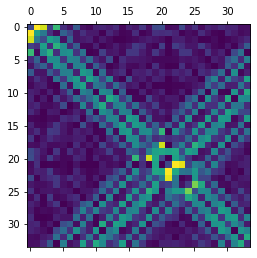

In [7]:
plt.matshow(np.abs(S))

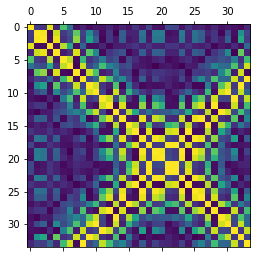

In [8]:
plt.matshow(np.abs(S_true))

In [14]:
S_true.shape

(34, 34)

In [15]:
S.shape

(34, 34)

In [11]:
np.shape(ψ_basis)

(34, 200)

In [12]:
np.shape(indices)

(34,)

In [13]:
%%time
S = ψ_basis.conj()@ψ_basis.T
H_proj = ψ_basis.conj()@H@ψ_basis.T

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 34 is different from 200)

In [45]:
%%time
s, V = eig(S)
indx = np.abs(s)>1e-12
lambda_s = np.diag(1/np.sqrt(s[indx]))
U = V[:, indx]@lambda_s

H_proj_red = U.T.conj()@H_proj@U

CPU times: user 307 ms, sys: 5.99 ms, total: 313 ms
Wall time: 307 ms


In [44]:
np.shape(H_proj_red)

(3, 3)

In [40]:
%%time
# could use eigh, H_proj_red is approximately hermitian
eigvalues, eigvectors = eigh(H_proj_red)

CPU times: user 486 µs, sys: 0 ns, total: 486 µs
Wall time: 406 µs


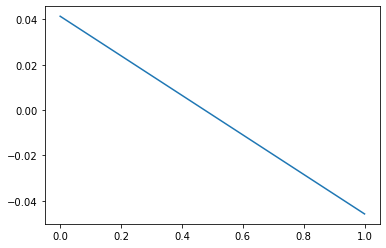

In [41]:
plt.plot(np.log10(np.diff(np.sort(np.real(eigvalues)))))

(0.0, 0.2)

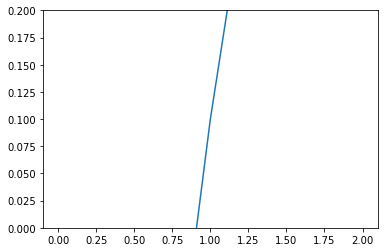

In [42]:
plt.plot(np.sort(np.real(eigvalues)))
plt.ylim([0, 0.2])

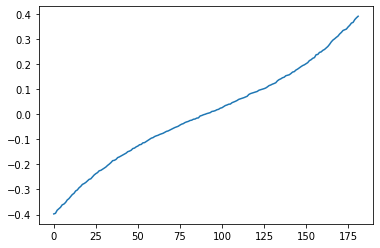

In [34]:
out_indx = a >= np.abs(eigvalues)
plt.plot(np.sort(np.real(eigvalues[out_indx])))